# Estimate cascade rates from structure functions

This example will demonstrate how to estimate cascade rates from two different velocity-based structure functions. Cascade rate estimations depend on the physical constraints of the turbulent system and this example specifically applies to 2D quasi-geostrophic fluid dynamics. 

**General procedure:**

1. Set up plot environment & load/format the data
2. Calculate structure functions
3. Estimate cascade rates
4. Plot cascade rates as a function of length scale

In [1]:
import warnings

import h5py
import matplotlib_inline.backend_inline
import seaborn as sns

warnings.filterwarnings("ignore")  # Ignore warnings for the purpose of this tutorial

sns.set_style(style="white")
sns.set_context("talk")
matplotlib_inline.backend_inline.set_matplotlib_formats("png", dpi=200)

## Initialize the data
We will use `h5py` to load a `.jld2` file, the output from [GeophysicalFlows.jl](https://fourierflows.github.io/GeophysicalFlowsDocumentation/stable/), a numerical ocean simulator written in Julia. The data consists of 2D (horizontal) fields simulated over a periodic domain. There are multiple snapshots of this data, corresponding to different times. We will select the last snapshot to analyze.

In [2]:
f = h5py.File("example_data/2layer_128.jld2", "r")
grid = f["grid"]
snapshots = f["snapshots"]

# Initialize the grid of x and y coordinates
x = grid["x"][()]
y = grid["y"][()]

# Grab the top layer and final snapshot of the simulation for u, and v
u = snapshots["u"]["20050"][0]
v = snapshots["v"]["20050"][0]

Make a couple of quick plots to see the velocity fields.

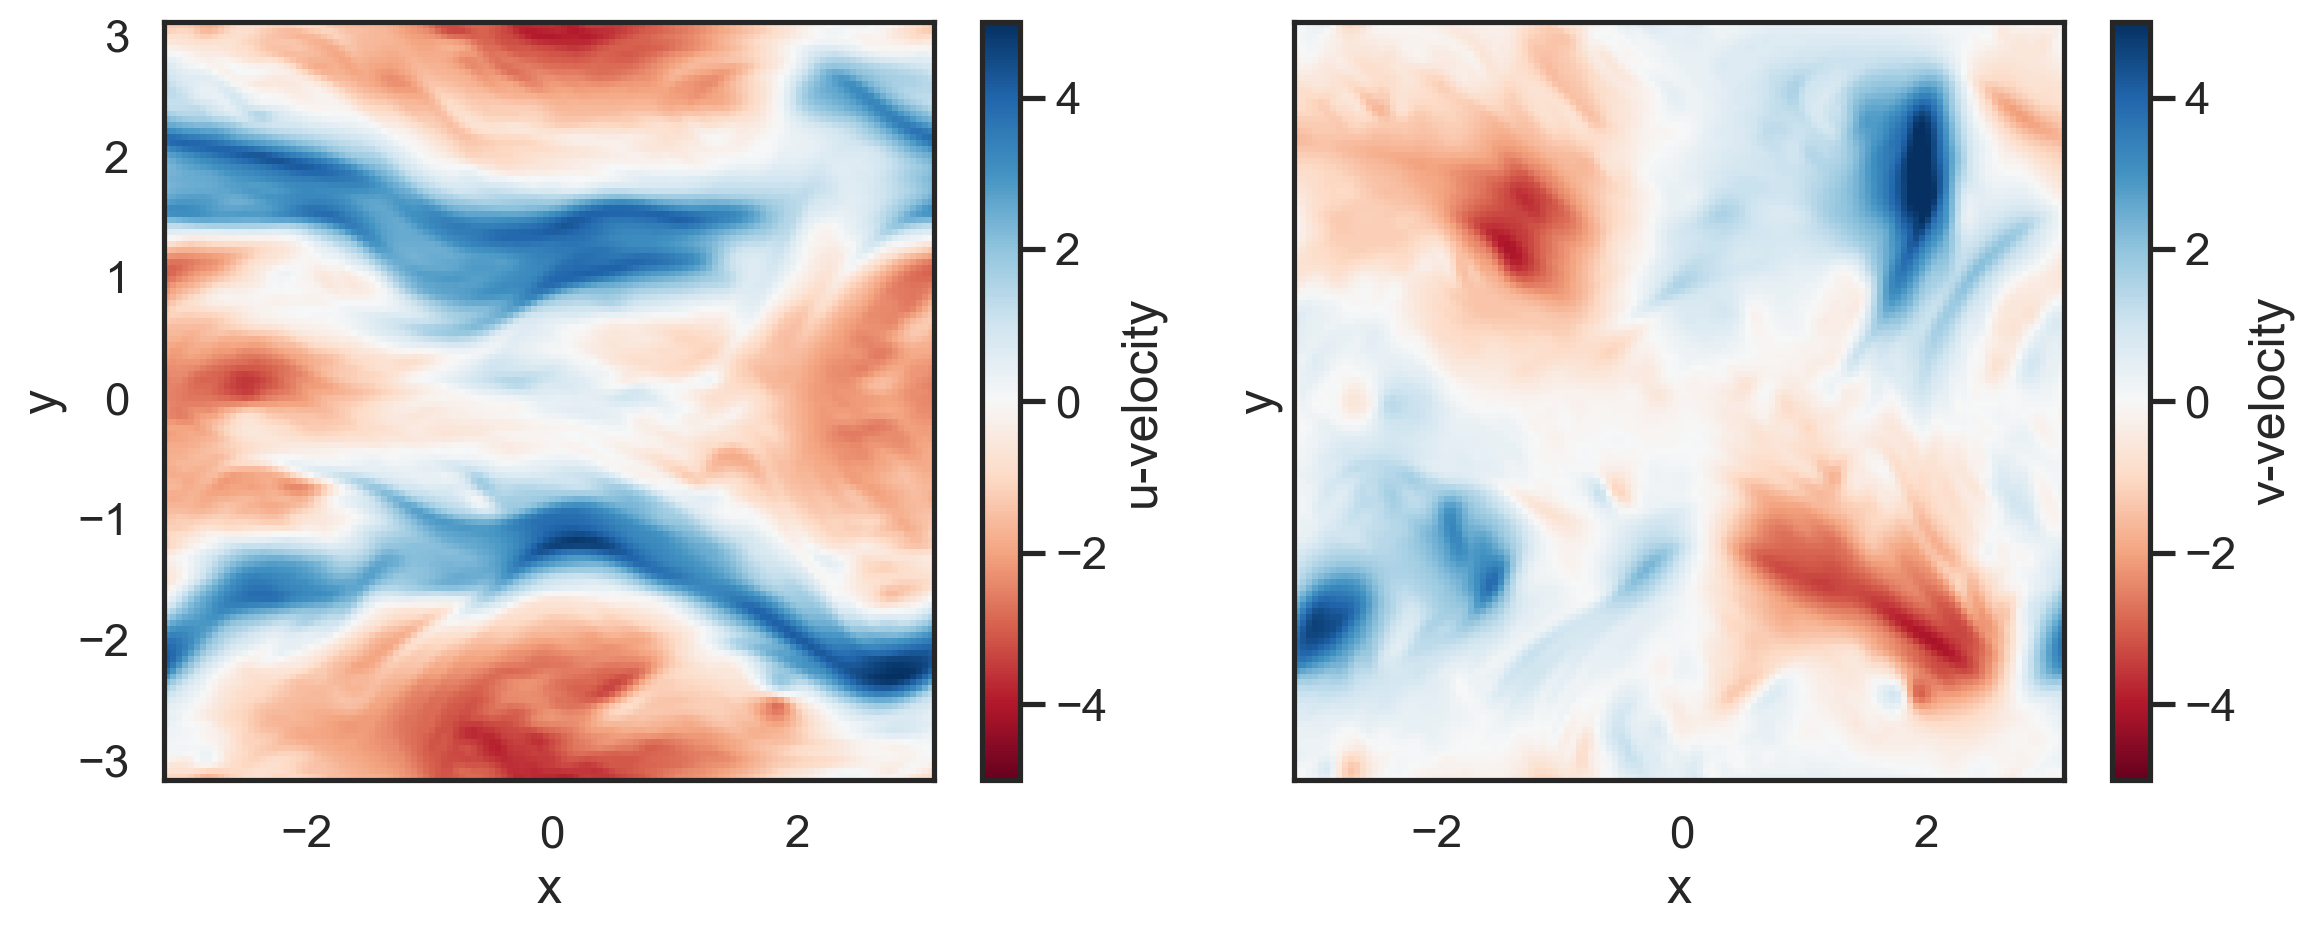

In [3]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12, 5))
p1 = ax1.pcolormesh(x, y, u, cmap="RdBu", vmin=-5, vmax=5)
p2 = ax2.pcolormesh(x, y, v, cmap="RdBu", vmin=-5, vmax=5)
fig.colorbar(p1, label="u-velocity")
fig.colorbar(p2, label="v-velocity")
ax1.set_xlabel("x")
ax2.set_xlabel("x")
ax1.set_ylabel("y")
ax2.set_ylabel("y")
plt.tight_layout()

## Calculate structure functions
Here we will calculate the advective velocity structure function and the third order longitudinal velocity structure function. We will calculate each structure function in the x-direction and the y-direction for a total of four unique structure functions.

In [4]:
import fluidsf

sf = fluidsf.generate_structure_functions(
    u,
    v,
    x,
    y,
    sf_type=["ASF_V", "LLL"],
)

## Estimate cascade rates

Different types of structure functions have different relationships to properties of turbulent flow, including cascade rates (inter-scale fluxes). Both velocity structure functions we have calculated can be related to the inverse energy cascade present in 2D turbulent systems. For more details about structure functions and their relevance to fluid properties, see the section [What are structure functions?](https://cassidymwagner.github.io/fluidsf/sfs.html)

The advective velocity structure function (`SF_advection_velocity` or $ASF_v$) and the third order longitudinal velocity structure function (`SF_LLL` or $SF_v^3$) have the following relationships with the inverse energy cascade rate in a 2D quasi-geostrophic system:

$\epsilon = -2 SF^3_v /3\mathbf{r}$

$\epsilon = - ASF_v /2$

where $\mathbf{r}$ is an array of separation differences (`x-diffs` or `y-diffs` in this case).

Now we can estimate the cascade rates using both structure functions.

In [5]:
epsilon_LLL_x = -2 * sf["SF_LLL_x"] / (3 * sf["x-diffs"])
epsilon_LLL_y = -2 * sf["SF_LLL_y"] / (3 * sf["y-diffs"])
epsilon_ASF_x = -sf["SF_advection_velocity_x"] / 2
epsilon_ASF_y = -sf["SF_advection_velocity_y"] / 2

## Plot cascade rates and compare


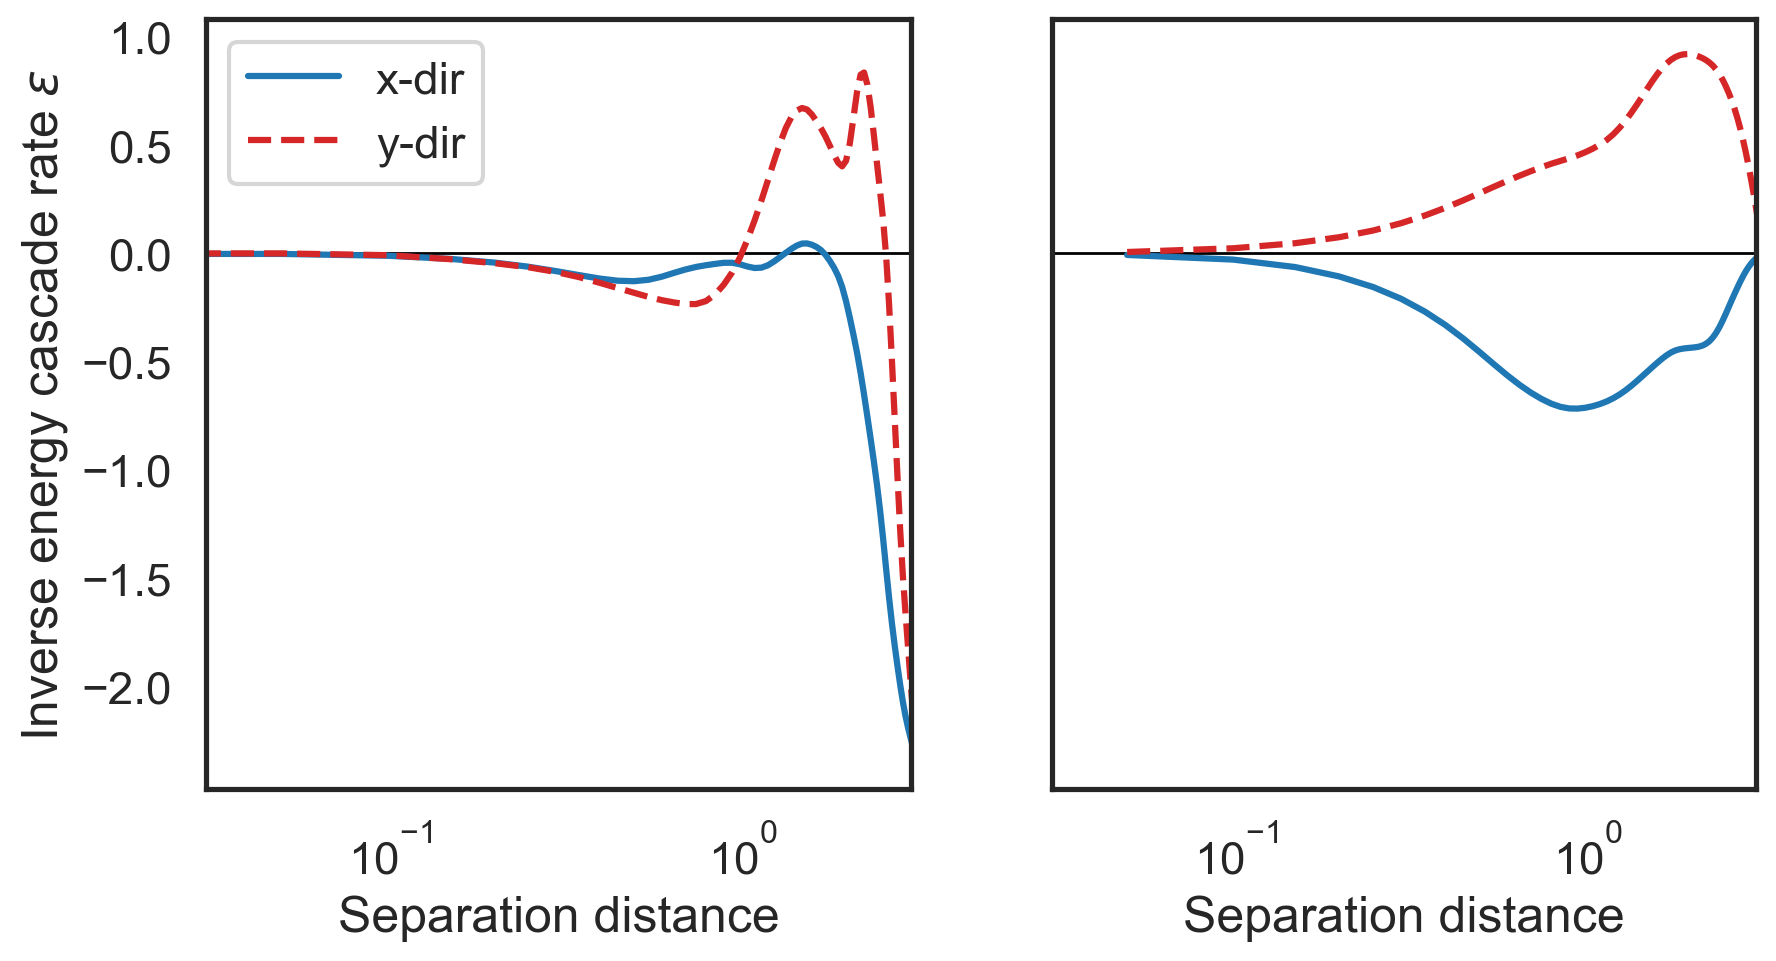

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

ax2.semilogx(sf["x-diffs"], epsilon_LLL_x, label=r"LLL$_x$", color="tab:blue")
ax2.semilogx(
    sf["y-diffs"],
    epsilon_LLL_y,
    label=r"LLL$_y$",
    color="tab:red",
    linestyle="dashed",
)
ax1.semilogx(sf["x-diffs"], epsilon_ASF_x, label=r"x-dir", color="tab:blue")
ax1.semilogx(
    sf["y-diffs"],
    epsilon_ASF_y,
    label=r"y-dir",
    color="tab:red",
    linestyle="dashed",
)


ax1.set_ylabel(r"Inverse energy cascade rate $\epsilon$")
ax1.set_xlabel(r"Separation distance")
ax2.set_xlabel(r"Separation distance")
ax1.set_xlim(3e-2, 3e0)
ax2.set_xlim(3e-2, 3e0)
ax1.legend()
ax1.hlines(0, 3e-2, 3e0, color="k", lw=1, zorder=0)
ax2.hlines(0, 3e-2, 3e0, color="k", lw=1, zorder=0);

## Notes on estimation accuracy

Getting an accurate estimation of cascade rates from structure functions requires using more than one snapshot/observation to calculate structure functions. Combining this example with the previous example on calculating structure functions from multiple snapshots helps constrain error and variability when estimating cascades.

There are also several publications that use Bessel functions to estimate cascade rates from structure functions instead of simple scaling relations, as we have used here. For more information, see the section [What are structure functions?](https://cassidymwagner.github.io/fluidsf/sfs.html)